In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import C3XGate, CPhaseGate
from fractions import Fraction
from math import gcd
import pandas as pd
import numpy

In [12]:
def circuit35(qreq_q, creq_q):

    'function creates a custom quantum circuit for N = 35, base a = 8 and period r = 4.'

    qc = QuantumCircuit(qreq_q, creq_q) #initiate circuit
    qc.h(qreq_q[0])                     #first QFT, qubit qt1
    qc.h(qreq_q[1])                     #first QFT, qubit qt2
    qc.h(qreq_q[2])                     #first QFT, qubit qt3
    qc.x(qreq_q[-1])                    #flip the last L-qubit from default |0> to |1>
    qc.barrier()
    
    #1, 4 CCCNOTs that flip |111>|00001> into |111>|10110> (binary for 8^7mod35 = 22)
    qc.append(C3XGate(), [0,1,2,3])     
    qc.append(C3XGate(), [0,1,2,4])     #2
    qc.append(C3XGate(), [0,1,2,6])     #3
    qc.append(C3XGate(), [0,1,2,7])     #4
    #qc.barrier()
    
    #1, 3 CNOT's that flip |110>|10110> into |110>|11101> (binary for 8^6mod35 = 29)
    qc.ccx(qreg_q[0], qreg_q[1], qreg_q[4])         
    qc.ccx(qreq_q[0], qreg_q[1], qreg_q[6])
    qc.cx(qreg_q[1], qreg_q[7])
    #qc.barrier()
    
    #1, 3 CNOT's that flip |101>|11101> into |111>|01000> (binary for 8^5mod35 = 8)
    qc.ccx(qreg_q[0], qreq_q[2], qreg_q[3])     
    qc.ccx(qreg_q[0], qreq_q[2], qreg_q[5])
    ## qc.cx(qreg_q[0], qreg_q[7]) #(2)
    #qc.barrier()
 
    #1, 3 CNOT's that flip |100>|01000> into |100>|00001> (binary for 8^4mod35 = 1)
    qc.cx(qreg_q[0], qreg_q[4])
    ## qc.cx(qreg_q[0], qreg_q[7]) #(2)
    #qc.barrier()
       
    #1, 3 CNOT's that flip |011>|00001> into |011>|10110> (binary for 8^3mod35 = 22)
    #qc.ccx(qreg_q[1], qreq_q[2], qreg_q[3])
    #qc.ccx(qreg_q[1], qreq_q[2], qreg_q[5])
    #qc.ccx(qreg_q[1], qreq_q[2], qreg_q[6])
    #qc.ccx(qreg_q[1], qreg_q[2], qreg_q[7])
    #qc.barrier()
    
    #1, 3 CNOT's that flip |010>|10110> into |010>|11101> (binary for 8^2mod35 = 29)
    #qc.cx(qreg_q[1], qreg_q[4]) #(1)
    #qc.cx(qreg_q[1], qreg_q[6])
    #qc.cx(qreg_q[1], qreg_q[7])
    #qc.barrier()

    #1, 3 CNOT's that flip |001>|11101> into |001>|01000> (binary for 8^1mod35 = 8)
    #qc.cx(qreg_q[2], qreg_q[3])
    #qc.cx(qreg_q[2], qreg_q[5])
    #qc.cx(qreg_q[2], qreq_q[7])
    #qc.barrier()
    
    #qc.x(qreq_q[0])                     #x=0 (|000> -> |111>) Otherwise CCCNOT will not flip target bits
    #qc.x(qreq_q[1])
    #qc.x(qreq_q[2])
    #qc.cx(qreg_q[1], qreg_q[4]) #(1)
    #qc.cx(qreg_q[1], qreg_q[7])
    qc.barrier()

    qc.h(qreq_q[0])
    qc.append(CPhaseGate(90).control(0), [qreg_q[0], qreg_q[1]])
    qc.append(CPhaseGate(45).control(0), [qreq_q[0], qreq_q[2]])
    qc.h(qreq_q[1])
    qc.append(CPhaseGate(90).control(0), [qreq_q[1], qreq_q[2]])
    qc.h(qreq_q[2])
    qc.barrier()

    qc.measure(qreg_q[0], creg_q[0])
    qc.measure(qreg_q[1], creg_q[1])
    qc.measure(qreg_q[2], creg_q[2])



    return qc

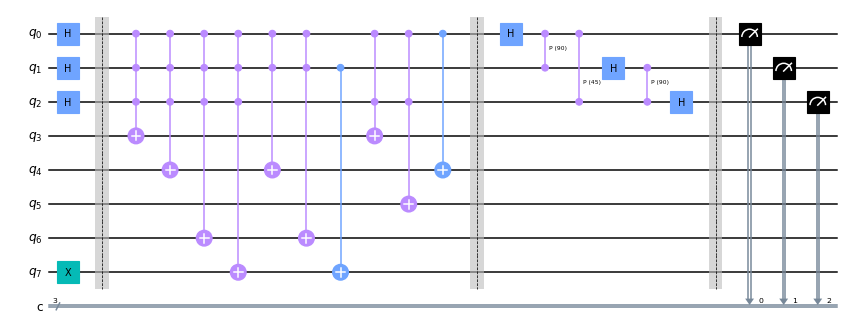

In [13]:
qreg_q = QuantumRegister(8, 'q')
creg_q = ClassicalRegister(3,'c')
circuit = circuit35(qreg_q, creg_q)
circuit.draw(output='mpl', scale=0.75)


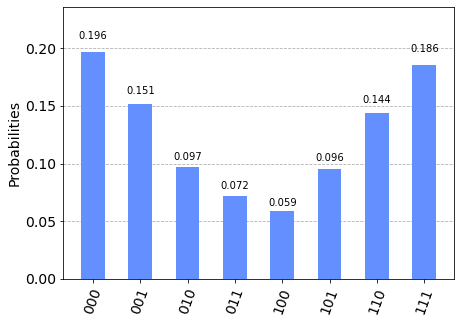

In [14]:
#Phase estimation step:
backend = Aer.get_backend('qasm_simulator')
results = execute(circuit, backend).result()
counts = results.get_counts()
plot_histogram(counts)

In [15]:
t = 3
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**t)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**t} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df1 = pd.DataFrame(rows, columns=headers)
print(df1)
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(35)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

       Register Output       Phase
0  111(bin) =   7(dec)  7/8 = 0.88
1  100(bin) =   4(dec)  4/8 = 0.50
2  101(bin) =   5(dec)  5/8 = 0.62
3  001(bin) =   1(dec)  1/8 = 0.12
4  010(bin) =   2(dec)  2/8 = 0.25
5  110(bin) =   6(dec)  6/8 = 0.75
6  011(bin) =   3(dec)  3/8 = 0.38
7  000(bin) =   0(dec)  0/8 = 0.00
   Phase Fraction  Guess for r
0  0.875      7/8            8
1  0.500      1/2            2
2  0.625      5/8            8
3  0.125      1/8            8
4  0.250      1/4            4
5  0.750      3/4            4
6  0.375      3/8            8
7  0.000      0/1            1
